<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/master/romane_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install tslearn

In [10]:
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.2)


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from scipy.fftpack import fft,ifft

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[np.random.randint(len(self.symbols))]
      TS = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = np.random.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

In [12]:
nb_timeseries = 2000

gen = TS_generator(nb_timeseries=nb_timeseries, chunk_size=100) #default values but just for the syntax
X = gen.get_array()

In [13]:
#Apply MinMax Scaling
X_scaled = MinMaxScaler().fit_transform(X.T).T

#Apply Fourier Transform for test
X_ft = fft(X_scaled)
print(X_ft[0][:10]) #first 10 coefficients

[38.37246934-0.j          3.42803627-4.60786364j  6.19458833-4.19913895j
  0.99826306-4.99663452j -2.58479827-1.69168784j  3.68252779-4.27084004j
 -0.76925153-0.48672509j -0.7704222 -0.00880738j  1.63251731-4.88672038j
  0.74512143-2.27796911j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


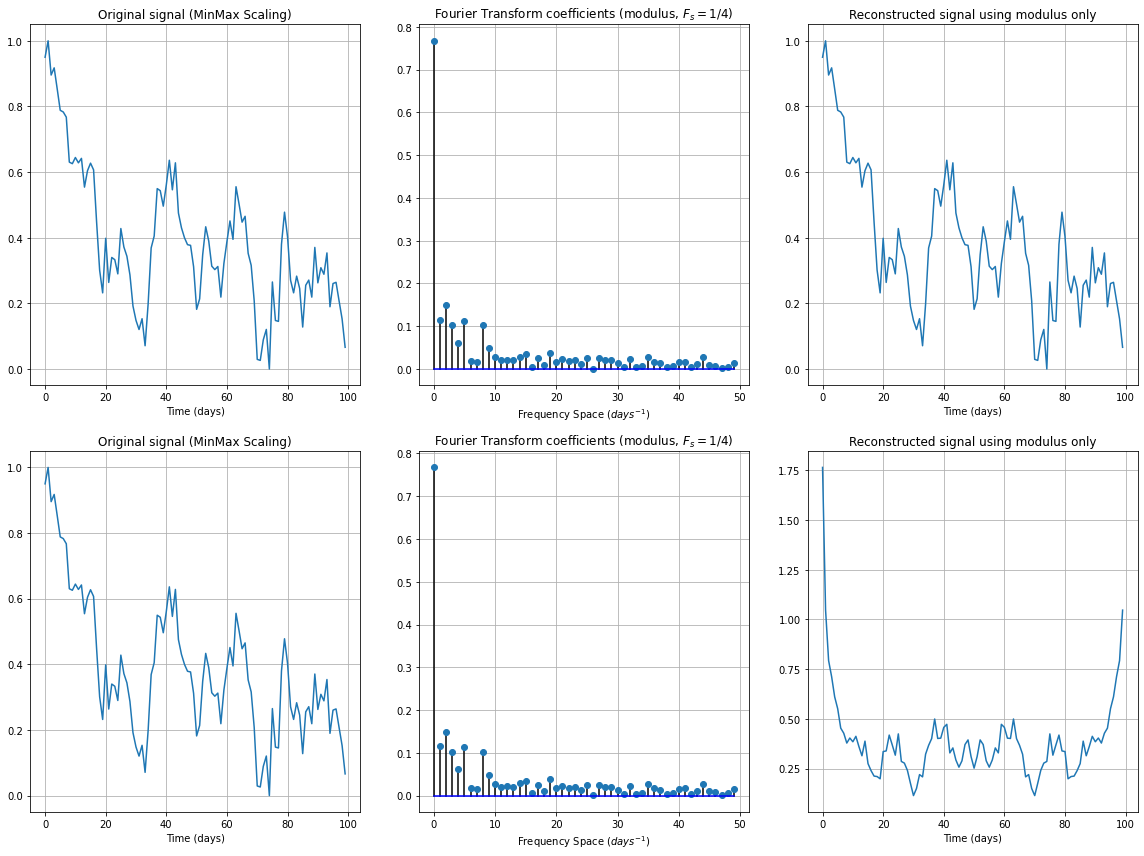

In [15]:
#First approach: Use modulus only
i=0
j=2

# sampling rate: f_max /2 - let's say the smallest pattern is 2 days
Fs = 1/4 
n = X_scaled.shape[1]
fr = Fs/2 * np.linspace(0,1,n//2)
X_ft_mod = 2/n * abs(X_ft)[:,0:np.size(fr)]

X_ft_reconstructed = ifft(abs(X_ft)).real
X_ft_complex_reconstructured = ifft(X_ft)

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (MinMax Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[0,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[0,1].grid()

axes[0,2].plot(X_ft_complex_reconstructured[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using modulus only')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[i])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (MinMax Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[1,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[1,1].grid()

axes[1,2].plot(X_ft_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using modulus only')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()

plt.tight_layout()
plt.show()

## 1. Concatenate Imaginary and Real Parts

In [26]:
#real/imaginary concat
X_ft_subs_ri = []

for i in X_ft:
  X_ft_subs_ri.append(i[1:12])

X_ft_subs_ri = np.array(X_ft_subs_ri)
X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

X_ft_subs_ri[:5]

array([[ 3.42803627e+00,  6.19458833e+00,  9.98263060e-01,
        -2.58479827e+00,  3.68252779e+00, -7.69251531e-01,
        -7.70422196e-01,  1.63251731e+00,  7.45121430e-01,
        -7.26522987e-01,  9.29520540e-01, -4.60786364e+00,
        -4.19913895e+00, -4.99663452e+00, -1.69168784e+00,
        -4.27084004e+00, -4.86725087e-01, -8.80737705e-03,
        -4.88672038e+00, -2.27796911e+00, -1.14470719e+00,
        -4.34333058e-01],
       [-1.33348723e+00,  3.79922023e+00, -1.30751363e+00,
        -2.44141254e+00,  1.38534834e-02, -5.18167710e-01,
        -2.69859786e+00, -7.44955555e-01, -1.09538519e+00,
        -2.72124935e-01, -1.41803447e+00,  1.27281088e+01,
         7.15684335e+00,  3.98114405e+00,  3.27157915e+00,
         2.64948907e+00,  2.98305409e+00,  1.69492173e+00,
         1.44287160e+00,  3.14920292e+00,  1.49004481e+00,
         5.41679919e-01],
       [ 1.33637969e+01,  2.08292648e+00,  1.41830274e+00,
         2.94659031e-01,  1.13452611e-01,  1.07512721e+00,
    

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


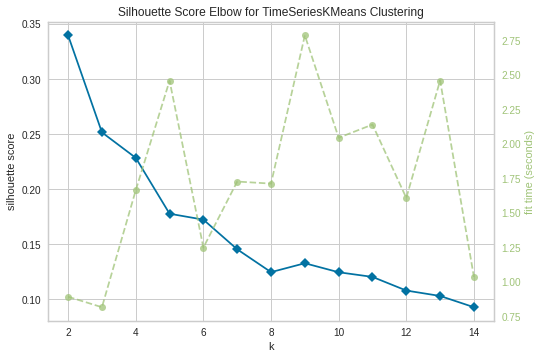

In [41]:
#Find best k
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model1 = TimeSeriesKMeans()
visualizer = KElbowVisualizer(model1, k=(2,15), metric='silhouette')

visualizer.fit(X_ft_subs_ri)        # Fit the data to the visualizer
visualizer.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


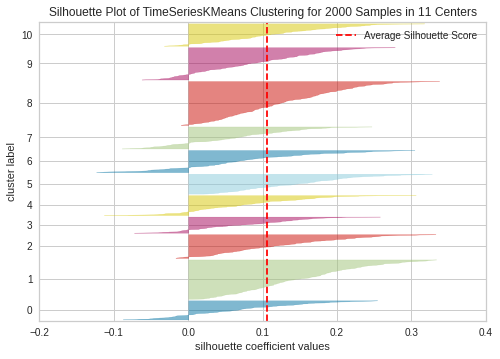

In [27]:
#silhouette scores for each cluster for best k
model1 = TimeSeriesKMeans(n_clusters=11)
visualizer = SilhouetteVisualizer(model1, colors='yellowbrick')
visualizer.fit(X_ft_subs_ri) 
visualizer.show()

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


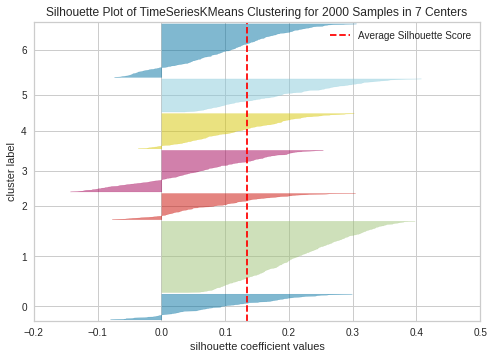

In [47]:
model_ri = TimeSeriesKMeans(n_clusters=7)
visualizer_ri = SilhouetteVisualizer(model_ri, colors='yellowbrick')
visualizer_ri.fit(X_ft_subs_ri) 
visualizer_ri.show()

## 2. Module

In [39]:
#taking only the modulus
X_ft_subs = []

for i in X_ft:
  X_ft_subs.append(i[1:13])

X_ft_subs = np.array(X_ft_subs)
X_ft_subs = X_ft_subs.real
X_ft_subs[:10]

array([[  3.42803627,   6.19458833,   0.99826306,  -2.58479827,
          3.68252779,  -0.76925153,  -0.7704222 ,   1.63251731,
          0.74512143,  -0.72652299,   0.92952054,  -0.3693869 ],
       [ -1.33348723,   3.79922023,  -1.30751363,  -2.44141254,
          0.01385348,  -0.51816771,  -2.69859786,  -0.74495556,
         -1.09538519,  -0.27212494,  -1.41803447,  -0.39434059],
       [ 13.36379693,   2.08292648,   1.41830274,   0.29465903,
          0.11345261,   1.07512721,  -1.13927854,  -3.59994317,
          0.28591712,   0.67308151,   1.87112198,   0.19729854],
       [ -3.47367496,  -0.19644057,   0.22070585,   0.48288135,
         -0.96135824,  -0.81714882,  -0.59042482,  -0.67296654,
         -1.53793194,  -0.58022212,   0.0935316 ,  -1.2311872 ],
       [  6.69320822,   4.52218288,   3.98580855,   2.85490076,
         -0.67819741,   0.66870822,   0.08448526,   0.30528757,
          1.11681486,   0.71356545,   0.01847819,  -0.21162133],
       [  1.06752126,  -1.50862563,

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


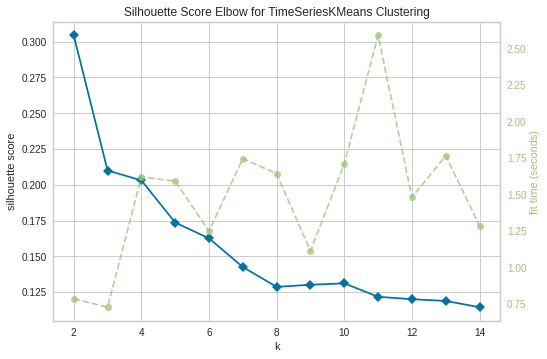

In [40]:
#Find best k
model2 = TimeSeriesKMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15), metric = 'silhouette')

visualizer2.fit(X_ft_subs)       # Fit the data to the visualizer
visualizer2.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


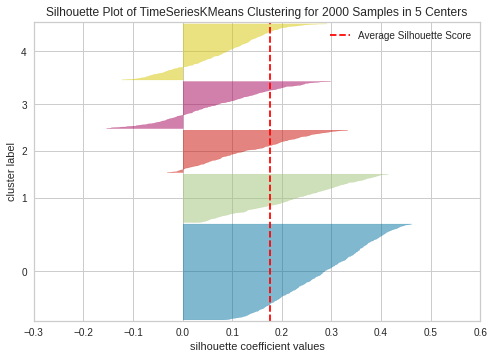

In [38]:
model2 = TimeSeriesKMeans(n_clusters=5)
visualizer2 = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer2.fit(X_ft_subs_ri) 
visualizer2.show()   

## 3. Optimization of the number of coefficient

### 3.1 Imaginery + real

2 to 3 coefficients


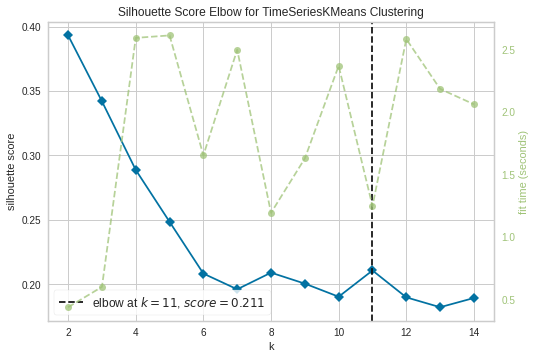

2 to 4 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


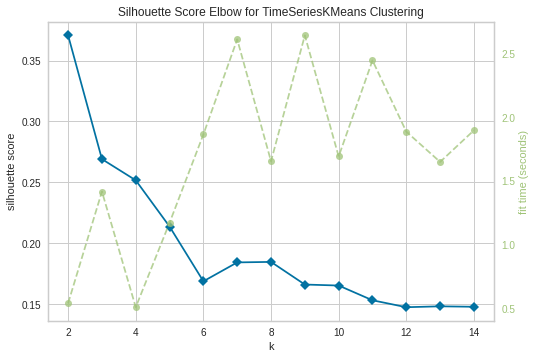

2 to 5 coefficients


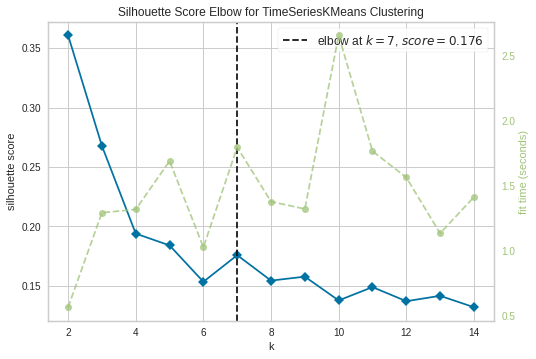

2 to 6 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


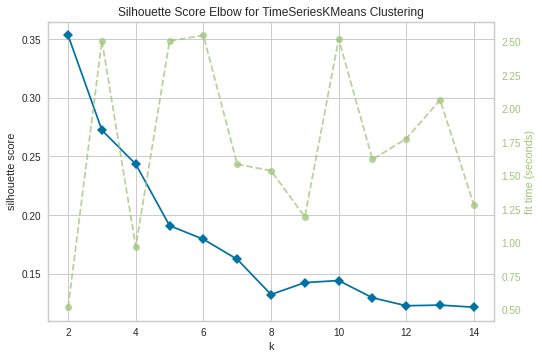

2 to 7 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


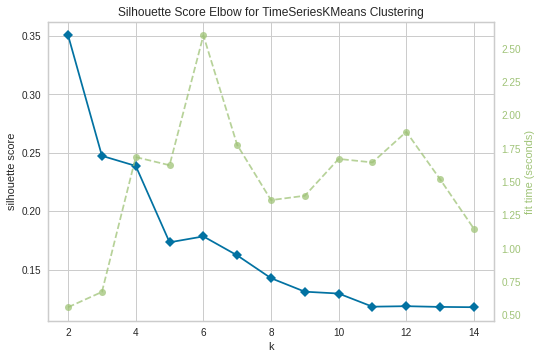

2 to 8 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


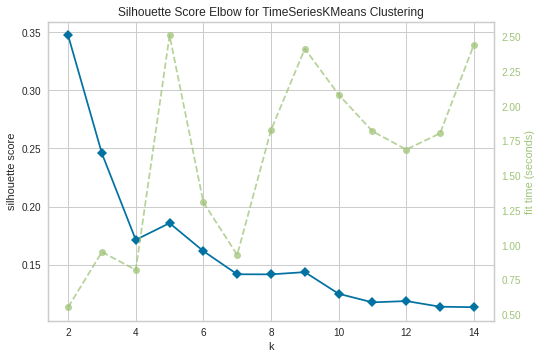

2 to 9 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


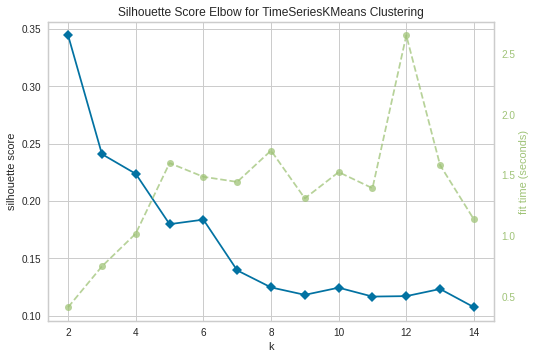

2 to 10 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


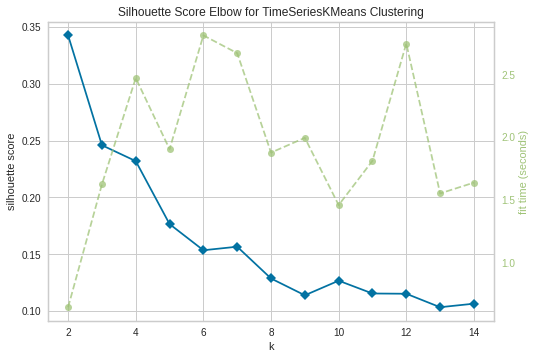

2 to 11 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


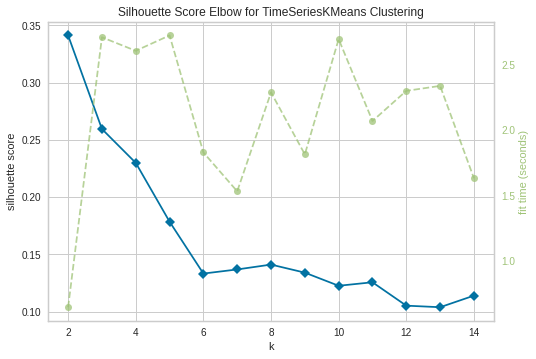

2 to 12 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


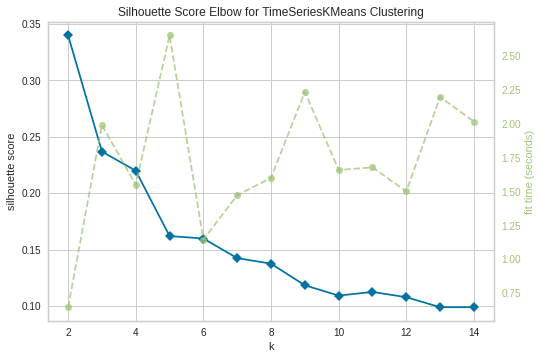

2 to 13 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


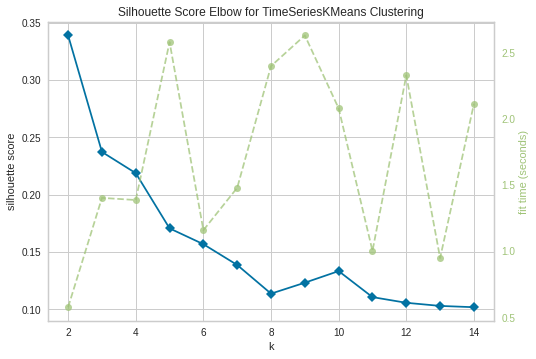

In [45]:
for j in range(3,14):

  X_ft_subs_ri = []

  for i in X_ft:
    X_ft_subs_ri.append(i[1:j])

  X_ft_subs_ri = np.array(X_ft_subs_ri)
  X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

  model_ri_best = TimeSeriesKMeans()
  visualizer_ri_best = KElbowVisualizer(model_ri_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_ri_best.fit(X_ft_subs_ri)       # Fit the data to the visualizer
  visualizer_ri_best.show();



2 to 3 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


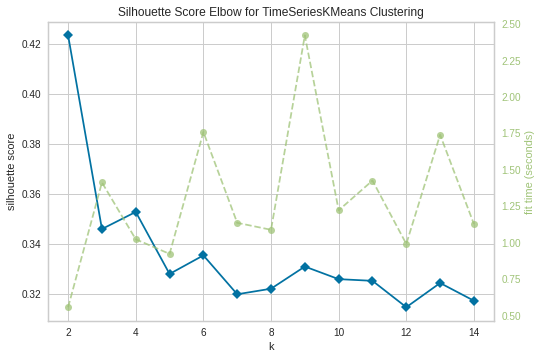

2 to 4 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


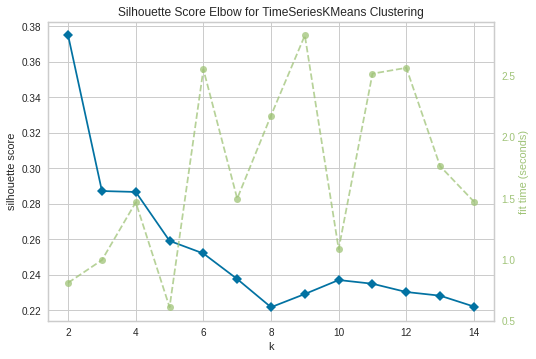

2 to 5 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


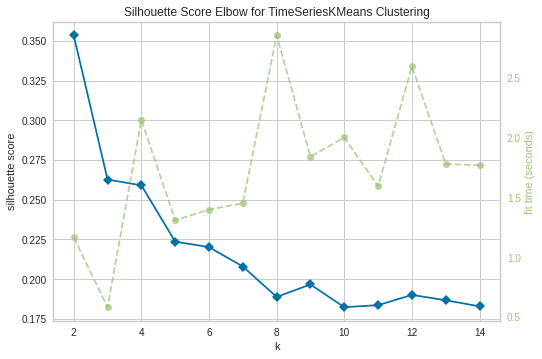

2 to 6 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


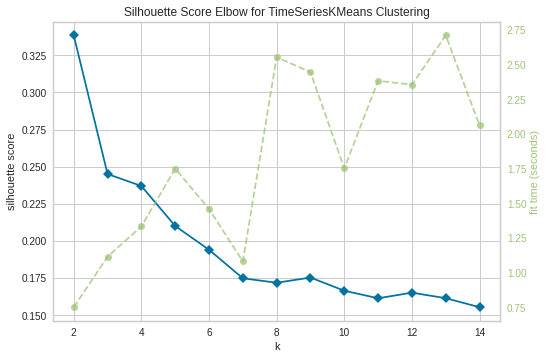

2 to 7 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


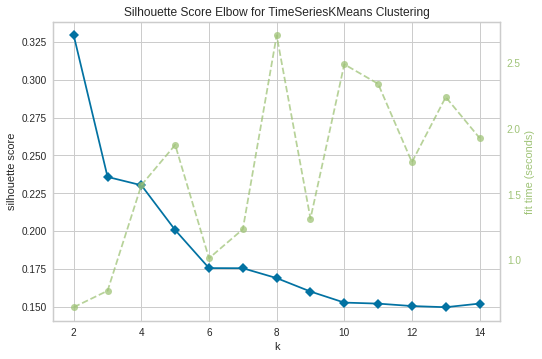

2 to 8 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


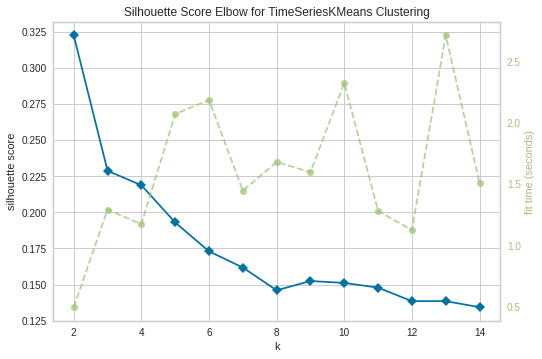

2 to 9 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


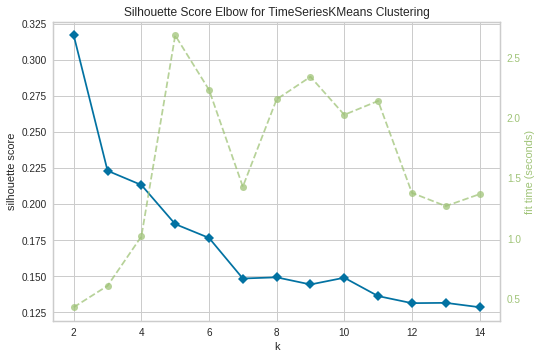

2 to 10 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


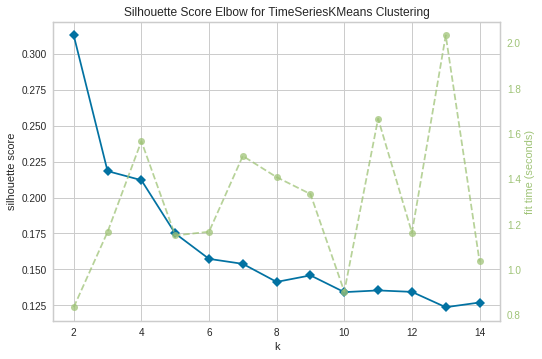

2 to 11 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


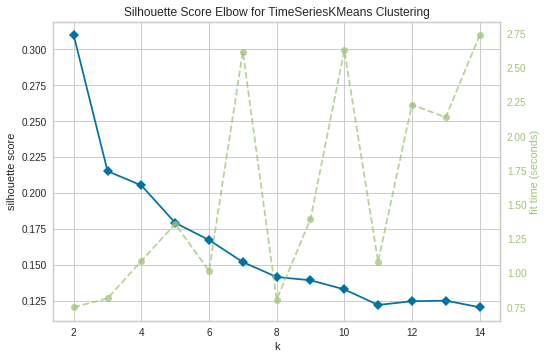

2 to 12 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


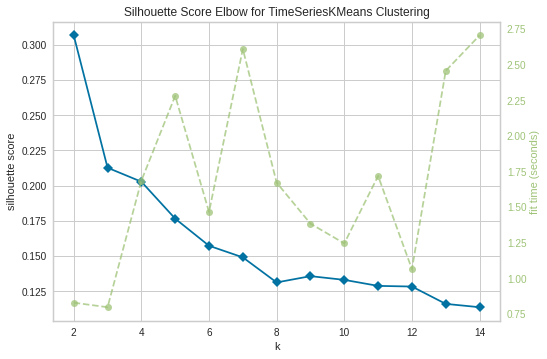

2 to 13 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


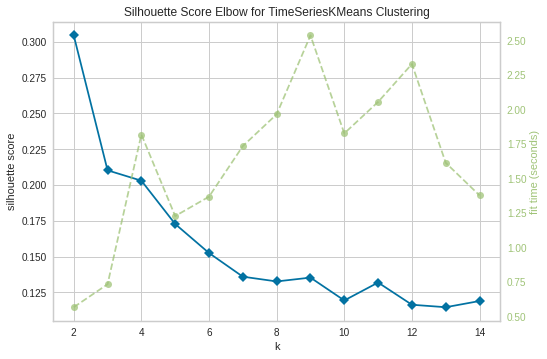

In [46]:
for j in range(3,14):

  X_ft_subs = []

  for i in X_ft:
    X_ft_subs.append(i[1:j])

  X_ft_subs = np.array(X_ft_subs)
  X_ft_subs = X_ft_subs.real
  X_ft_subs[:10]

  model_subs_best = TimeSeriesKMeans()
  visualizer_subs_best = KElbowVisualizer(model_subs_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_subs_best.fit(X_ft_subs)       # Fit the data to the visualizer
  visualizer_subs_best.show();

